In [11]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home/gsatopo1/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator

from scipy import integrate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

LC_path='/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/'

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def LC_params():
    h=0.678
    zmin = 2.5;zmax = 3.5
    zmid=(zmax+zmin)/2
    R=700
    ang_lim=10*u.deg
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = True, external_SFR = 'UniverseMachine_SFR',
                      sig_extSFR=0.3,
                      SFR_pars=dict(),
                      angular_supersample=1,
                      spectral_supersample=1,
                      cube_mode='inner_cube',
                      Nmu=20,
                      kmin=0.02*u.Mpc**-1,
                      kmax=1*u.Mpc**-1,
                      dk=0.02*u.Mpc**-1,
                      seed=0)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                    RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim,
                    RA_min=-ang_lim,RA_max=ang_lim, DEC_min=-ang_lim,DEC_max=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin,tobs=6000*u.hr,
                    do_angular_smooth=True,
                    do_spectral_smooth=True)
    
    nu_CO=115.271*u.GHz
    dnu=nu_CO/(1+zmid)/R
    model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                            models=dict(CO_J10=dict(model_name='CO_Li16',
                                                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),                          
                             do_intensity=False))
    obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                       dnu=dnu, 
                       Tsys=0*u.Jy/u.sr))
    obs_params.update(model_params)

    return obs_params

In [3]:
LC_CO=make_measurements(LC_params())

In [4]:
LC_CO.update(Nmu=20)
PkCO_0=LC_CO.Pk_0
PkCO_2=LC_CO.Pk_2

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:678: UserWarning: % of emitters of CO_J10 line left out filtering = 0.22616551377608718
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


### Comparison with theory

In [5]:
def neg_vector(K, Theta, Phi):
    return K, np.pi-Theta, Phi+np.pi

def add_vector(K1, Theta1, Phi1, K2, Theta2, Phi2):
    X=K1*np.cos(Phi1)*np.sin(Theta1) + K2*np.cos(Phi2)*np.sin(Theta2)
    Y=K1*np.sin(Phi1)*np.sin(Theta1) + K2*np.sin(Phi2)*np.sin(Theta2)
    Z=K1*np.cos(Theta1) + K2*np.cos(Theta2)

    R=np.sqrt(X**2 + Y**2 + Z**2)
    ThetaR=np.arccos(Z/R)
    PhiR=np.arctan(Y/X)
    PhiR[(X>0)&(Y<0)]+=2*np.pi
    PhiR[(X<0)&(Y>=0)]+=np.pi
    PhiR[(X<0)&(Y<0)]+=np.pi
    PhiR[(X==0)&(Y>=0)]=np.pi/2
    PhiR[(X==0)&(Y<0)]=3*np.pi/2
    return R, ThetaR, PhiR

def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, sfr_pars):
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100

    nu=115.271*u.GHz
    Z=3
    DZ=1
    nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
    R=700
    dnu=nu/(1+Z)/R

    model_params = dict(nu=115.271*u.GHz, nuObs=nuObs, 
                        sigma_scatter=0.3,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file=SFR_file,sig_SFR=0.3),                     
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=False, smooth=False, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=1000, nmu=10000, 
                        Tmin_VID=1e-5*u.Jy/u.sr,Tmax_VID=500*u.Jy/u.sr,nT=2**21,
#                        Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                        Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                        dndL_Lcut=10*u.Lsun,
                        do_Jysr=False)
    obs_params = dict(Delta_nu=Dnu, dnu=dnu,
                      #Tsys_NEFD=(45*u.K/(69.4)**0.5)*np.sqrt(4/400), #We get the improvement here as an efficient way
                      Tsys_NEFD=0*u.K,
                      Nfeeds=19*2,
                      beam_FWHM=2*u.arcmin,
                      tobs=1000*u.hr,
                      Omega_field=1000*u.deg**2,
                      Nfield=1)    
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

In [6]:
m = lim(lim_params('/home/gsatopo1/code/LIM Lightcones/preLIMinary/SFR_tables/UM_sfr.dat','other'))

In [7]:
Pkres = m.Wkmax*(m.Pk_clust+m.Pk_shot)
Pk_interp = RegularGridInterpolator((m.k.value, np.arccos(m.mu[::-1])),Pkres[::-1, :].T.value, bounds_error=False, fill_value=0)

Note: redshifts have been re-sorted (earliest first)


In [8]:
#m.update(nk=30, nmu=31)
hubble=0.678

nth=20
k=np.copy(LC_CO.k_Pk_poles.value*hubble)
thk=np.linspace(0+0.001, np.pi-0.001, nth)
phk=np.linspace(0+0.001, 2*np.pi-0.001, 20)

qe = np.logspace(-4,2,101)
q = 0.5*(qe[:-1]+qe[1:])
thq = np.linspace(0+0.001, np.pi-0.001, 90)
phq=np.linspace(0+0.001, 2*np.pi-0.001, 80)

qgrid=np.tile(q[:,None,None], (1, len(thq), len(phq)))
thqgrid=np.tile(thq[None,:,None], (len(q), 1, len(phq)))
phqgrid=np.tile(phq[None,None,:], (len(q), len(thq), 1))

qxgrid=qgrid*np.cos(phqgrid)*np.sin(thqgrid)
qygrid=qgrid*np.sin(phqgrid)*np.sin(thqgrid)
qzgrid=qgrid*np.cos(thqgrid)

Lpar=LC_CO.Lbox[0].to_value(u.Mpc)
Lperp=LC_CO.Lbox[1].to_value(u.Mpc)
Vol=(LC_CO.Lbox[0]*LC_CO.Lbox[1]*LC_CO.Lbox[2]).to_value(u.Mpc**3)

Wx=2*np.sin(qxgrid*Lperp/2)/qxgrid
Wy=2*np.sin(qygrid*Lperp/2)/qygrid
Wz=2*np.sin(qzgrid*Lpar/2)/qzgrid
Wconv = Wx*Wy*Wz

Pconv = np.zeros((len(k), nth))
for ik in range(len(k)):
    for ith in range(nth):
        Pk_phi=np.zeros((len(phk)))
        for iph in range(len(phk)):
            neg_qgrid, neg_thqgrid, neg_phqgrid = neg_vector(qgrid, thqgrid, phqgrid)
            qsum_grid,thsum_grid,phsum_grid = add_vector(k[ik],thk[ith], phk[iph], neg_qgrid, neg_thqgrid, neg_phqgrid)
            Pk_phi[iph] = np.trapz(np.trapz(np.trapz(qgrid**2*np.sin(thqgrid)*(np.abs(Wconv)**2)*Pk_interp((qsum_grid,thsum_grid))/(2*np.pi)**3, phq, axis=-1), thq, axis=-1), q, axis=-1)
        Pconv[ik, ith] = np.trapz(Pk_phi/Vol/(2*np.pi), phk)

In [14]:
Pconv.shape

(30, 31)

In [9]:
from scipy.special import legendre

P0_conv=0.5*np.trapz(Pconv*np.sin(np.tile(thk[None,:], (len(k), 1))),thk,axis=-1)
L2 = legendre(2)
P2_conv=2.5*np.trapz(Pconv*np.sin(np.tile(thk[None,:], (len(k), 1)))*L2(np.cos(np.tile(thk[None,:], (len(k), 1)))),thk,axis=-1)

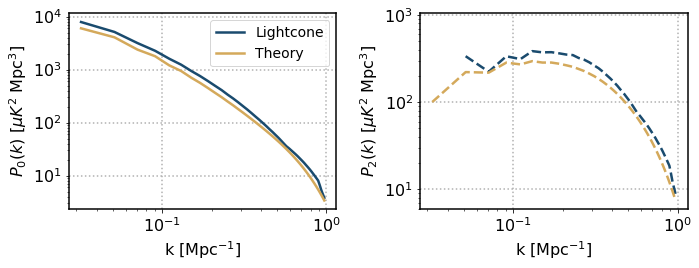

In [17]:
hubble=0.678

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.loglog(LC_CO.k_Pk_poles*hubble, PkCO_0/(hubble**3), label='Lightcone')
plt.loglog(k, P0_conv, label='Theory')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('$P_0(k)$ [$\mu K^2$ Mpc$^3$]')
plt.grid(linestyle='dotted', linewidth=1.5)
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(LC_CO.k_Pk_poles[PkCO_2>=0]*hubble, PkCO_2[PkCO_2>=0]/(hubble**3), 'C0')
plt.loglog(LC_CO.k_Pk_poles[PkCO_2<0]*hubble, abs(PkCO_2[PkCO_2<0])/(hubble**3), 'C0--')
plt.loglog(k[P2_conv>=0], P2_conv[P2_conv>=0], 'C1')
plt.loglog(k[P2_conv<0], abs(P2_conv[P2_conv<0]), 'C1--')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('$P_2(k)$ [$\mu K^2$ Mpc$^3$]')
plt.grid(linestyle='dotted', linewidth=1.5)

plt.tight_layout()
plt.savefig('Pk_LCxTheory_woRSD.png', bbox_inches='tight', dpi=200)

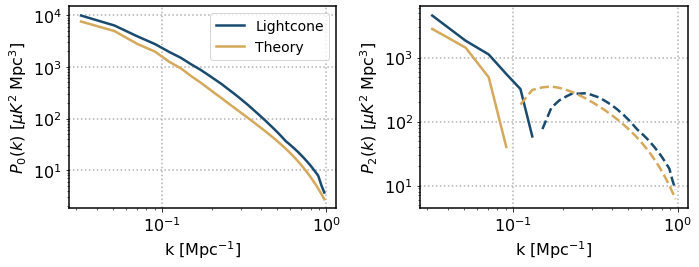

In [53]:
hubble=0.678

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.loglog(LC_CO.k_Pk_poles*hubble, PkCO_0/(hubble**3), label='Lightcone')
plt.loglog(k, P0_conv, label='Theory')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('$P_0(k)$ [$\mu K^2$ Mpc$^3$]')
plt.grid(linestyle='dotted', linewidth=1.5)
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(LC_CO.k_Pk_poles[PkCO_2>=0]*hubble, PkCO_2[PkCO_2>=0]/(hubble**3), 'C0')
plt.loglog(LC_CO.k_Pk_poles[PkCO_2<0]*hubble, abs(PkCO_2[PkCO_2<0])/(hubble**3), 'C0--')
plt.loglog(k[P2_conv>=0], P2_conv[P2_conv>=0], 'C1')
plt.loglog(k[P2_conv<0], abs(P2_conv[P2_conv<0]), 'C1--')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('$P_2(k)$ [$\mu K^2$ Mpc$^3$]')
plt.grid(linestyle='dotted', linewidth=1.5)

plt.tight_layout()
plt.savefig('Pk_LCxTheory_wRSD.png', bbox_inches='tight', dpi=200)

In [42]:
2*np.pi/LC_CO.Vsurvey**(1/3)

<Quantity 0.0036782 1 / Mpc>

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:678: UserWarning: % of emitters of CO_J10 line left out filtering = 0.2260928678521218
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


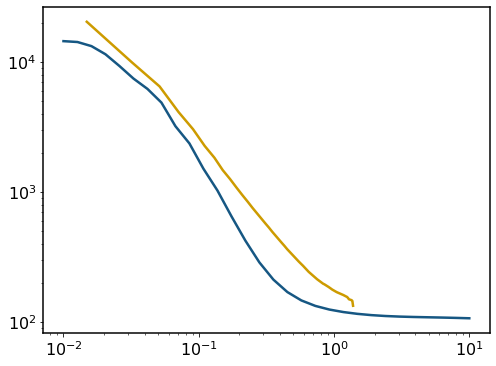

In [84]:
plt.loglog(k, P0_conv)
plt.loglog(LC_CO.k_Pk_poles.to(1/u.Mpc), LC_CO.Pk_0.to(u.uK**2*u.Mpc**3))

(0.001, 3)

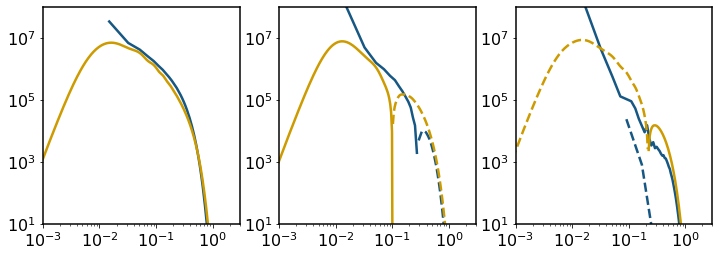

In [77]:
hubble=0.678

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.loglog(LC_CO.k_Pk_poles*hubble, PkCO/(hubble**3))
plt.loglog(m_CO.k, m_CO.Pk_0)
plt.ylim(1e1,1e8)
plt.xlim(1e-3, 3)

plt.subplot(1,3,2)
plt.loglog(LC_CO.k_Pk_poles[PkCO_2>=0]*hubble, PkCO_2[PkCO_2>=0]/(hubble**3), 'C0')
plt.loglog(LC_CO.k_Pk_poles[PkCO_2<0]*hubble, abs(PkCO_2[PkCO_2<0])/(hubble**3), 'C0--')
plt.loglog(m_CO.k[m_CO.Pk_2>=0], m_CO.Pk_2[m_CO.Pk_2>=0], 'C1')
plt.loglog(m_CO.k[m_CO.Pk_2<0], abs(m_CO.Pk_2[m_CO.Pk_2<0]), 'C1--')
plt.ylim(1e1,1e8)
plt.xlim(1e-3, 3)

plt.subplot(1,3,3)
plt.loglog(LC_CO.k_Pk_poles[PkCO_4>=0]*hubble, PkCO_4[PkCO_4>=0]/(hubble**3), 'C0')
plt.loglog(LC_CO.k_Pk_poles[PkCO_4<0]*hubble, abs(PkCO_4[PkCO_4<0])/(hubble**3), 'C0--')
plt.loglog(m_CO.k[m_CO.Pk_4>=0], m_CO.Pk_4[m_CO.Pk_4>=0], 'C1')
plt.loglog(m_CO.k[m_CO.Pk_4<0], abs(m_CO.Pk_4[m_CO.Pk_4<0]), 'C1--')

plt.ylim(1e1,1e8)
plt.xlim(1e-3, 3)

In [76]:
m_CO.update(nmu=20, smooth=False)

In [22]:
def Gauss(x,mu,sig2):
    '''
    Gaussian PDF
    '''
    exparg = -0.5*x**2/sig2
    norm = (2.*np.pi*sig2)**0.5
    return np.exp(exparg)/norm

def Add_noise(T,Tout,PT,Pzero,sig2):
    '''
    Adds a noise PDF to a given PDF convoluting them
    
    params: 
    T: temperature vector
    PT: PDF of temperature
    Pzero: The value of P(T=0) (i.e., P(N=0))
    sig2: variance of the noise PDF
    '''
    conv = np.zeros(len(Tout))*PT.unit
    for i in range(len(Tout)):
        conv[i] = np.trapz(Gauss(Tout[i]-T,0.,sig2)*PT,T)
    conv += Pzero*Gauss(Tout,0.,sig2)
    
    return conv

def get_VID_T(M, NTbins):
    sig2 = M.sigma_N**2
    Nsigma = 7

    n0=int(1e6)
    tt2min=np.min([-Nsigma*sig2.value**0.5, -M.Tmean])
    TT2=np.concatenate((np.linspace(tt2min,0,n0)*M.T.unit,M.T))
    ind_mean=int(np.argmin(np.abs(TT2-M.Tmean)))
    PT=np.concatenate((np.concatenate((np.zeros(n0-(ind_mean-n0))*M.PT.unit,M.PT)), np.zeros(ind_mean-n0)*M.PT.unit))
    Toute = np.linspace(tt2min,M.Tedge[-1].value,2**8+1)*M.T.unit
    Tout = vut.binedge_to_binctr(Toute)

    PT_total = Add_noise(TT2,Tout,PT,M.PT_zero,sig2)
    print(len(PT_total), len(TT2), len(Tout), np.trapz(PT_total, Tout))

    Tmin_i,Tmax_i,nT_i = 0*u.K,10*u.K,NTbins
    Tbin_edge=np.linspace(Tmin_i, Tmax_i, nT_i+1)
    Tbin=(Tbin_edge[:-1]+Tbin_edge[1:])/2.

    Balpha_tot_overNvox = vut.pdf_to_histogram(Tout,PT_total,Tbin_edge,1,0.*Tbin.unit,0.)
    Balpha=Balpha_tot_overNvox*M.Nvox
    
    return Tbin, Balpha

def get_VID_I(M, NTbins):
    sig2 = ((M.sigma_N/np.sqrt(M.tpix*M.Nfeeds)).to(u.Jy/u.sr))**2
    Nsigma = 7

    n0=int(1e6)
    TT2min=np.min([-Nsigma*sig2.value**0.5, -M.Tmean.value])
    TT2=np.concatenate((np.linspace(TT2min,0,n0)*M.T.unit,M.T))
    ind_mean=int(np.argmin(np.abs(TT2-M.Tmean)))
    
    PT=np.concatenate((np.concatenate((np.zeros(n0-(ind_mean-n0))*M.PT.unit,M.PT)), np.zeros(ind_mean-n0)*M.PT.unit))
    Toute = np.linspace(TT2min,M.Tedge[-1].value,2**8+1)*M.T.unit
    Tout = vut.binedge_to_binctr(Toute)

    PT_total = Add_noise(TT2,Tout,PT,M.PT_zero,sig2)
    print(len(PT_total), len(TT2), len(Tout), np.trapz(PT_total, Tout))

    Tmin_i,Tmax_i,nT_i = -1e3*u.Jy/u.sr,6e4*u.Jy/u.sr,NTbins
    Tbin_edge=np.linspace(Tmin_i, Tmax_i, nT_i+1)
    Tbin=(Tbin_edge[:-1]+Tbin_edge[1:])/2.

    Balpha_tot_overNvox = vut.pdf_to_histogram(Tout,PT_total,Tbin_edge,1,0.*Tbin.unit,0.)
    Balpha=Balpha_tot_overNvox*M.Nvox
    
    return Tout, PT_total

In [23]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, sfr_pars, line):
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
    
    if line=='CO':
        nu=115.271*u.GHz
        Z=3
        DZ=1
        nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
        model_params = dict(nu=115.271*u.GHz, nuObs=nuObs, 
                            sigma_scatter=0.3,
                            hmf_model='Tinker', 
                            bias_model='Tinker10', 
                            model_type='ML',
                            Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                            model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file=SFR_file,sig_SFR=0.3),                     
                            model_name='TonyLi', 
                            do_onehalo=True, do_RSD=True, smooth=False, 
                            kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                            nk=50, nmu=30, 
                            Tmin_VID=1e-5*u.Jy/u.sr,Tmax_VID=500*u.Jy/u.sr,nT=2**21,
    #                        Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                            dndL_Lcut=10*u.Lsun,
                            do_Jysr=False)
        obs_params = dict(Delta_nu=Dnu, dnu=31.25*u.MHz,
                          #Tsys_NEFD=(45*u.K/(69.4)**0.5)*np.sqrt(4/400), #We get the improvement here as an efficient way
                          Tsys_NEFD=0*u.K,
                          Nfeeds=19*2,
                          beam_FWHM=2*u.arcmin,
                          tobs=1000*u.hr,
                          Omega_field=1000*u.deg**2,
                          Nfield=1)    
        obs_params.update(model_params)
        obs_params.update(cosmo_fid)
    elif line=='CII':
        nu=1900.539*u.GHz
        Z=3
        DZ=1
        
        nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
        model_params = dict(nu=nu, nuObs=nuObs,
                            sigma_scatter=0.3,
                            hmf_model='Tinker', 
                            bias_model='Tinker10', 
                            model_type='ML',
                            Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                            model_name='SilvaCII',
                            model_par={'SFR_file':'Silva15_SFR_params.dat','a':1.,'b':6.9647}, 
                            do_onehalo=True, do_RSD=False, smooth=True, 
                            kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1,
                            nk=512, nmu=10, 
                            Tmin_VID=1e-5*u.Jy/u.sr,Tmax_VID=1e7*u.Jy/u.sr,nT=2**21,
    #                        Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e12*u.Lsun,Ngal_max=30,
                            dndL_Lcut=10*u.Lsun,
                            do_Jysr=True)
        obs_params = dict(Delta_nu=Dnu, dnu=0.938*u.GHz,
                          #Tsys_NEFD=(45*u.K/(69.4)**0.5)*np.sqrt(4/400), #We get the improvement here as an efficient way
                          Tsys_NEFD=1e-10*u.Jy*u.s**(1./2),
                          Nfeeds=30,
                          beam_FWHM=3*u.arcmin,
                          tobs=8*u.hr,
                          Omega_field=400*u.deg**2,
                          Nfield=1)    
        obs_params.update(model_params)
        obs_params.update(cosmo_fid)
    return obs_params